In [4]:
!pip install yfinance statsmodels


[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
data = yf.download("TSLA", start = "2023-01-01", end = "2025-01-01")

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2023-01-03,108.099998,118.800003,104.639999,118.470001,231402800
2023-01-04,113.639999,114.589996,107.519997,109.110001,180389000
2023-01-05,110.339996,111.750000,107.160004,110.510002,157986300
2023-01-06,113.059998,114.389999,101.809998,103.000000,220911100
2023-01-09,119.769997,123.519997,117.110001,118.959999,190284000


In [13]:
ts = data['Close']

ts.head()

Ticker,TSLA
Date,
2023-01-03,108.099998
2023-01-04,113.639999
2023-01-05,110.339996
2023-01-06,113.059998
2023-01-09,119.769997


In [14]:
ts.isna().sum()

Ticker
TSLA    0
dtype: int64

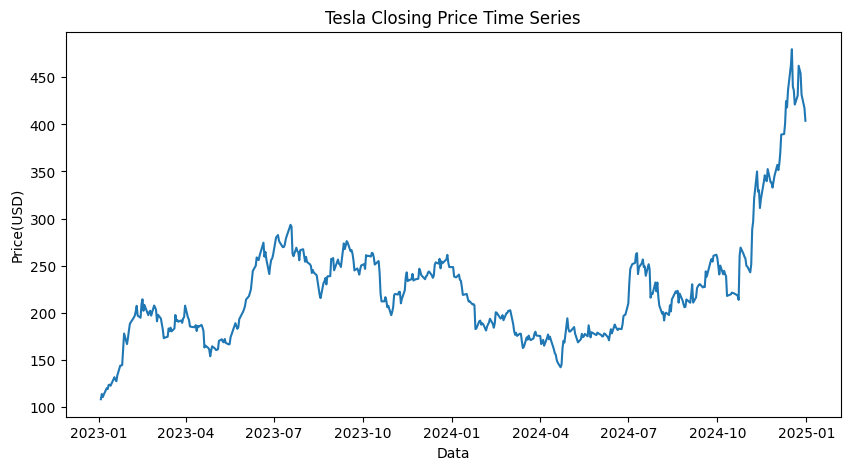

In [15]:
plt.figure(figsize = (10,5))
plt.plot(ts)
plt.title("Tesla Closing Price Time Series")
plt.xlabel("Data")
plt.ylabel("Price(USD)")
plt.show()

In [16]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")

adf_test(ts)

ADF Statistic: -0.8124566820962108
p-value: 0.8154355988841779
Critical Value 1%: -3.443470002903981
Critical Value 5%: -2.867326248740681
Critical Value 10%: -2.569851849873108


In [17]:
ts_diff = ts.diff().dropna()

adf_test(ts_diff)

ADF Statistic: -21.309578560638986
p-value: 0.0
Critical Value 1%: -3.443496379464
Critical Value 5%: -2.8673378563200003
Critical Value 10%: -2.569858036


In [18]:
train_size = int(len(ts)*0.8)
train, test = ts[:train_size], ts[train_size:]

print("Training size:", len(train))
print("Testing size;", len(test))

Training size: 401
Testing size; 101


<Figure size 1200x500 with 0 Axes>

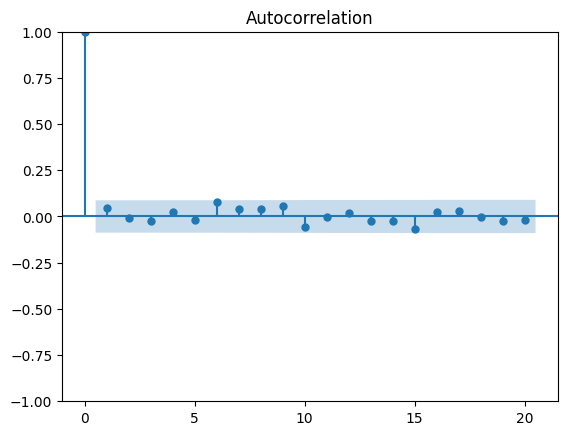

<Figure size 1200x500 with 0 Axes>

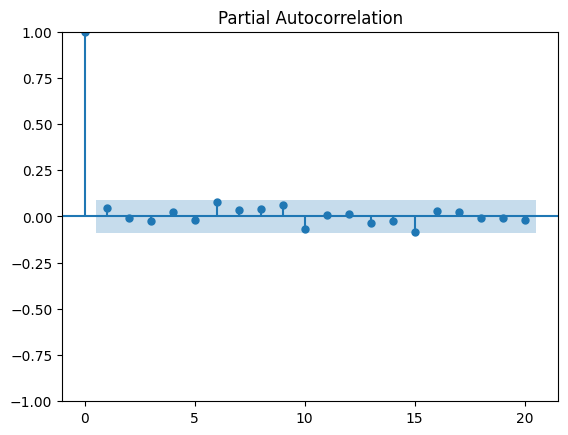

In [19]:
plt.figure(figsize=(12,5))
plot_acf(ts_diff, lags=20)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(ts_diff, lags=20)
plt.show()

In [20]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                  401
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1353.953
Date:                Sun, 21 Dec 2025   AIC                           2713.906
Time:                        19:39:04   BIC                           2725.880
Sample:                             0   HQIC                          2718.648
                                - 401                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8741      0.196      4.470      0.000       0.491       1.257
ma.L1         -0.8430      0.218     -3.869      0.000      -1.270      -0.416
sigma2        51.0015      2.604     19.589      0.0

In [31]:
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast.values, index=test.index)

In [32]:
print(forecast.head())
print(forecast.tail())

Date
2024-08-08    190.925045
2024-08-09    190.195239
2024-08-12    189.557337
2024-08-13    188.999765
2024-08-14    188.512407
dtype: float64
Date
2024-12-24    185.129670
2024-12-26    185.129668
2024-12-27    185.129667
2024-12-30    185.129665
2024-12-31    185.129664
dtype: float64


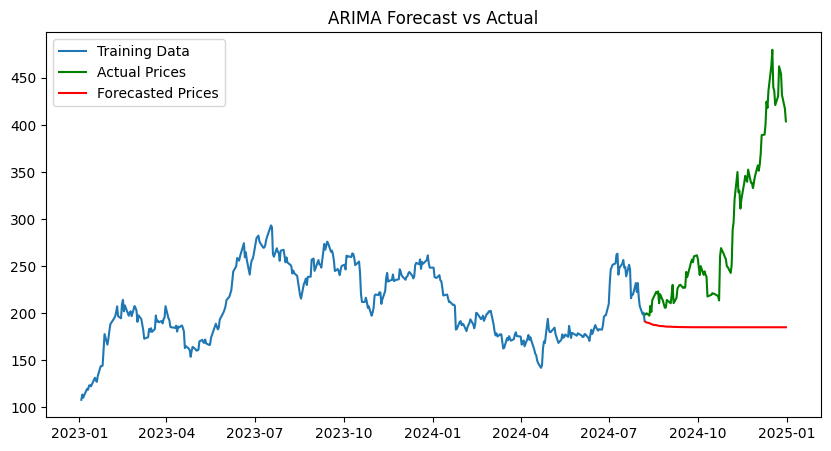

In [35]:
# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(train, label="Training Data")
plt.plot(test, label="Actual Prices", color='green')
plt.plot(forecast, label="Forecasted Prices", color='red')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

In [37]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)

MAE : 100.3271650718034
MSE : 16449.07554990734
RMSE: 128.25394945149773


In [42]:
history = train.copy()
predictions = []

for t in range(len(test)):
    try:
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1).iloc[0]
        predictions.append(yhat)

        # add actual observation
        history = pd.concat([history, test.iloc[t:t+1]])

    except Exception as e:
        print(f"Error at step {t}: {e}")
        predictions.append(np.nan)

predictions = pd.Series(predictions, index=test.index)
predictions = predictions.dropna()

walk_rmse = np.sqrt(mean_squared_error(test.loc[predictions.index], predictions))
print("Walk-forward RMSE:", walk_rmse)

Walk-forward RMSE: 12.972382702833075


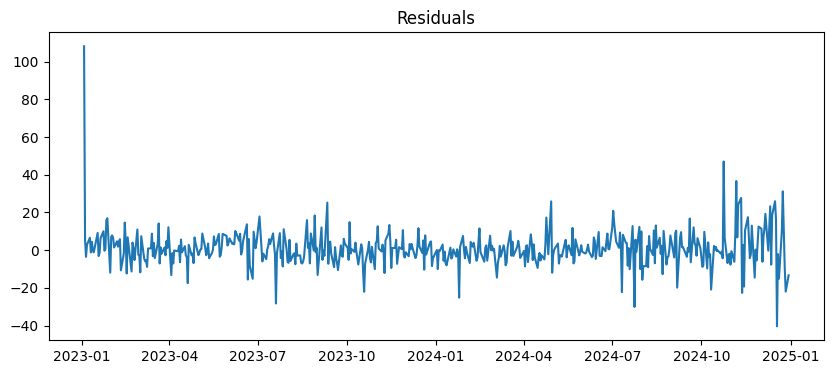

In [43]:
residuals = model_fit.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

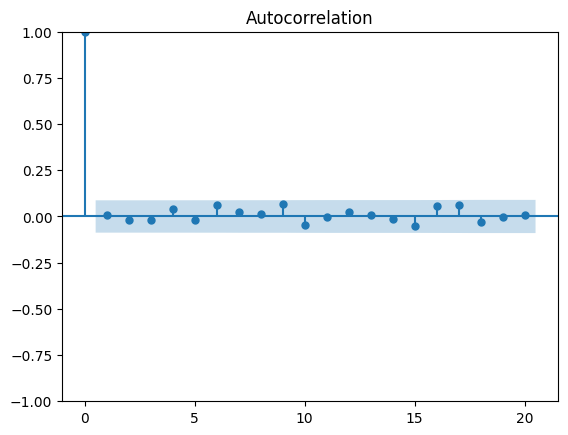

In [44]:
plot_acf(residuals, lags=20)
plt.show()